In [1]:
#Install the required libraries
!git lfs install
!pip install datasets
!pip install transformers
!pip install accelerate -U

Updated Git hooks.
Git LFS initialized.


In [2]:
#Import the required libraries
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datasets
from datasets import load_dataset,config
import torch
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
config.progress_bar_type = None

In [3]:
#Load the ncbi dataset to fine tune the pre-trained model
med_dis = load_dataset("ncbi_disease")

In [4]:
#Exploring the dataset
#It consists of train,validation and test data
med_dis

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [5]:
import pandas as pd
df_train=pd.DataFrame(med_dis["train"][:])
df_validation=pd.DataFrame(med_dis["validation"][:])
df_test=pd.DataFrame(med_dis["test"][:])

In [6]:
df_new=pd.concat([df_train,df_validation,df_test])

**Pre-processing the data**

In [7]:
import nltk
import string
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords

def preprocess(tokens):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    # Remove punctuation and numbers and convert to lower
    tokens = [word.lower() for word in tokens if word not in string.punctuation and not word.isdigit()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens
df_new['cleaned_tokens'] = df_new['tokens'].apply(preprocess)


**EDA on the cleaned tokens**

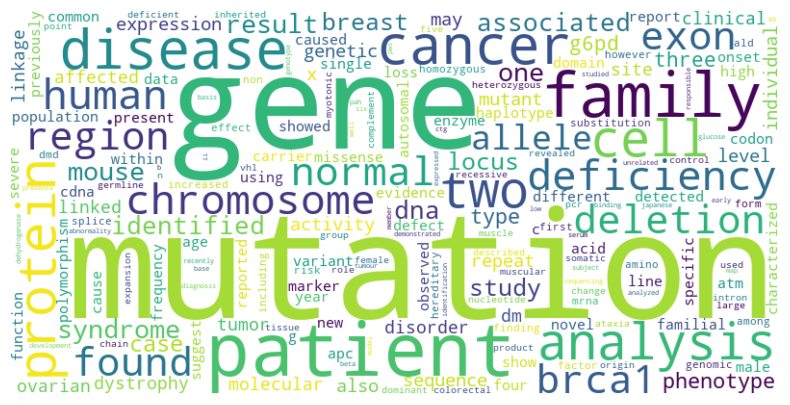

In [9]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
word_counts = Counter(word for tokens in df_new['cleaned_tokens'] for word in tokens)

# Create a word cloud based on word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The most commonly occuring words in the NCBI dataset are words such as mutation, disease,patient and gene.

In [10]:
df_new

,id,tokens,ner_tags,cleaned_tokens
0,0,"[Identification, of, APC2, ,, a, homologue, of...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[identification, apc2, homologue, adenomatous,..."
1,1,"[The, adenomatous, polyposis, coli, (, APC, ),...","[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[adenomatous, polyposis, coli, apc, tumour, su..."
2,2,"[Complex, formation, induces, the, rapid, degr...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[complex, formation, induces, rapid, degradati..."
3,3,"[In, colon, carcinoma, cells, ,, loss, of, APC...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[colon, carcinoma, cell, loss, apc, lead, accu..."
4,4,"[Here, ,, we, report, the, identification, and...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[report, identification, genomic, structure, a..."
...,...,...,...,...
936,936,"[In, an, attempt, to, resolve, this, issue, ,,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[attempt, resolve, issue, comprehensively, cha..."
937,937,"[These, reagents, detect, a, 220, -, kD, prote...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[reagent, detect, kd, protein, localized, disc..."
938,938,"[Immunohistochemical, staining, of, human, bre...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[immunohistochemical, staining, human, breast,..."
939,939,"[Conversely, ,, BRCA1, expression, was, reduce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[conversely, brca1, expression, reduced, undet..."


In [11]:
flattened_tokens = [token for sublist in df_new["cleaned_tokens"] for token in sublist]

# Create a set from the flattened tokens to obtain unique tokens
vocab = set(flattened_tokens)

In [12]:
vocab=list(vocab)

In [13]:
len(vocab)

8370

In [14]:
#Set of items present within the train dictionary
med_dis["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)}

In [15]:
#Tags/labels defined in the ncbi datset to leverage ner
med_dis["train"].features["ner_tags"].feature.names

['O', 'B-Disease', 'I-Disease']

In [16]:
MODEL_CKPT = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
NUM_OF_EPOCHS = 3
BATCH_SIZE = 16
STRATEGY = "epoch"
REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01
LR = 2e-5
DEVICE = torch.device("cpu")
STEPS = 35

**Tokenizing based on pre-trained model**

In [17]:
tokenizer=AutoTokenizer.from_pretrained(MODEL_CKPT)

In [21]:
#Preprocessing tokenizing and allignment
"""This function is used to assign -100 to the special tokens and mask the subword that is a part
 of the previous subword.This process is done for the data to adapt with the tokenizer model"""
def tokenize_and_align_labels(input_samples):
    tokenized_inputs = tokenizer(input_samples["tokens"], 
                                  truncation=True, 
                                  is_split_into_words=True)
    
    processed_labels = []
    
    for idx, ner_tags in enumerate(input_samples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        label_ids = [-100] + [ner_tags[word_idx] if word_idx is not None and word_idx != word_ids[i - 1] else -100 for i, word_idx in enumerate(word_ids[1:], start=1)]
        processed_labels.append(label_ids)
    
    tokenized_inputs["labels"] = processed_labels
    return tokenized_inputs

In [22]:
encoded_ds = med_dis.map(tokenize_and_align_labels,
                       batched=True,
                       remove_columns=
                        [
                            'ner_tags',
                            'tokens'
                        ]
                    )

Map:   0%|          | 0/5433 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

In [23]:
encoded_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 941
    })
})

In [24]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [25]:
id2label = {0: "O",
    1: "B-Disease",
    2: "I-Disease"}

tag_values = list(id2label.values())
label2id = {tag: idx for idx, tag in id2label.items()}
print(label2id)

{'O': 0, 'B-Disease': 1, 'I-Disease': 2}


In [26]:
#To save the model in the hub
model = (AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
encoded_ds['train'][:]

{'id': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '60',
  '61',
  '62',
  '63',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '80',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '90',
  '91',
  '92',
  '93',
  '94',
  '95',
  '96',
  '97',
  '98',
  '99',
  '100',
  '101',
  '102',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '118',
  '119',
  '120',
  '121',
  '122

In [28]:
!pip install evaluate seqeval

In [29]:
import evaluate

In [30]:
example = med_dis['train'][12]

example

{'id': '12',
 'tokens': ['The',
  'mutation',
  '(',
  'A',
  '-',
  '-',
  '>',
  'T',
  'at',
  'nt943',
  '+',
  '3',
  ')',
  'disrupts',
  'the',
  '3',
  'splice',
  'site',
  'of',
  'exon',
  '5',
  'leading',
  'to',
  'the',
  'deletion',
  'of',
  'this',
  'exon',
  'from',
  'MSH2',
  'mRNA',
  'and',
  'represents',
  'the',
  'only',
  'frequent',
  'MSH2',
  'mutation',
  'so',
  'far',
  'reported',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [31]:
label_list = tag_values

In [32]:
seqeval = evaluate.load("seqeval")

labels = [label_list[i] for i in example[f'ner_tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, 
                            axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(predictions=true_predictions, 
                              references=true_labels)
    
    return results

In [34]:
from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoModel,
    AutoTokenizer,
    EvalPrediction,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)

In [35]:
#Creating a Trainer arguments and defining each of them
args = TrainingArguments(
    "ncbi-finetuned-ner",
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

In [36]:
trainer = Trainer(model, 
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )
trainer.train()

  0%|          | 0/1020 [00:00<?, ?it/s]

{'loss': 1.1921, 'learning_rate': 1.9980392156862747e-05, 'epoch': 0.0}
{'loss': 0.338, 'learning_rate': 1.931372549019608e-05, 'epoch': 0.1}
{'loss': 0.1187, 'learning_rate': 1.862745098039216e-05, 'epoch': 0.21}
{'loss': 0.0776, 'learning_rate': 1.7941176470588237e-05, 'epoch': 0.31}
{'loss': 0.0678, 'learning_rate': 1.7254901960784314e-05, 'epoch': 0.41}
{'loss': 0.059, 'learning_rate': 1.6568627450980395e-05, 'epoch': 0.51}
{'loss': 0.0535, 'learning_rate': 1.5882352941176473e-05, 'epoch': 0.62}
{'loss': 0.0454, 'learning_rate': 1.519607843137255e-05, 'epoch': 0.72}
{'loss': 0.0386, 'learning_rate': 1.4509803921568629e-05, 'epoch': 0.82}
{'loss': 0.0529, 'learning_rate': 1.3823529411764706e-05, 'epoch': 0.93}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.058773986995220184, 'eval_Disease': {'precision': 0.7733812949640287, 'recall': 0.8958333333333334, 'f1': 0.8301158301158301, 'number': 960}, 'eval_overall_precision': 0.7733812949640287, 'eval_overall_recall': 0.8958333333333334, 'eval_overall_f1': 0.8301158301158301, 'eval_overall_accuracy': 0.9800791933706168, 'eval_runtime': 144.8902, 'eval_samples_per_second': 6.495, 'eval_steps_per_second': 0.407, 'epoch': 1.0}
{'loss': 0.0401, 'learning_rate': 1.3137254901960785e-05, 'epoch': 1.03}
{'loss': 0.0307, 'learning_rate': 1.2450980392156864e-05, 'epoch': 1.13}
{'loss': 0.0307, 'learning_rate': 1.1764705882352942e-05, 'epoch': 1.24}
{'loss': 0.0294, 'learning_rate': 1.1078431372549021e-05, 'epoch': 1.34}
{'loss': 0.0307, 'learning_rate': 1.03921568627451e-05, 'epoch': 1.44}
{'loss': 0.0327, 'learning_rate': 9.705882352941177e-06, 'epoch': 1.54}
{'loss': 0.0233, 'learning_rate': 9.019607843137256e-06, 'epoch': 1.65}
{'loss': 0.0274, 'learning_rate': 8.333333333333334e-06,

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.04853636026382446, 'eval_Disease': {'precision': 0.8224568138195777, 'recall': 0.8927083333333333, 'f1': 0.8561438561438561, 'number': 960}, 'eval_overall_precision': 0.8224568138195777, 'eval_overall_recall': 0.8927083333333333, 'eval_overall_f1': 0.8561438561438561, 'eval_overall_accuracy': 0.9847736457525411, 'eval_runtime': 146.4042, 'eval_samples_per_second': 6.427, 'eval_steps_per_second': 0.403, 'epoch': 2.0}
{'loss': 0.0213, 'learning_rate': 6.274509803921569e-06, 'epoch': 2.06}
{'loss': 0.0159, 'learning_rate': 5.588235294117647e-06, 'epoch': 2.16}
{'loss': 0.0145, 'learning_rate': 4.901960784313726e-06, 'epoch': 2.26}
{'loss': 0.0127, 'learning_rate': 4.215686274509805e-06, 'epoch': 2.37}
{'loss': 0.0201, 'learning_rate': 3.529411764705883e-06, 'epoch': 2.47}
{'loss': 0.0198, 'learning_rate': 2.843137254901961e-06, 'epoch': 2.57}
{'loss': 0.0158, 'learning_rate': 2.1568627450980393e-06, 'epoch': 2.68}
{'loss': 0.0182, 'learning_rate': 1.4705882352941177e-06, '

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.050685424357652664, 'eval_Disease': {'precision': 0.8354307841239109, 'recall': 0.8989583333333333, 'f1': 0.8660311088810838, 'number': 960}, 'eval_overall_precision': 0.8354307841239109, 'eval_overall_recall': 0.8989583333333333, 'eval_overall_f1': 0.8660311088810838, 'eval_overall_accuracy': 0.9856308935788056, 'eval_runtime': 145.0118, 'eval_samples_per_second': 6.489, 'eval_steps_per_second': 0.407, 'epoch': 3.0}
{'train_runtime': 8423.775, 'train_samples_per_second': 1.935, 'train_steps_per_second': 0.121, 'train_loss': 0.04596285656386731, 'epoch': 3.0}


TrainOutput(global_step=1020, training_loss=0.04596285656386731, metrics={'train_runtime': 8423.775, 'train_samples_per_second': 1.935, 'train_steps_per_second': 0.121, 'train_loss': 0.04596285656386731, 'epoch': 3.0})

In [39]:
train_final = trainer.train()

  0%|          | 0/1020 [00:00<?, ?it/s]

{'loss': 0.0112, 'learning_rate': 1.9980392156862747e-05, 'epoch': 0.0}
{'loss': 0.0215, 'learning_rate': 1.931372549019608e-05, 'epoch': 0.1}
{'loss': 0.0144, 'learning_rate': 1.862745098039216e-05, 'epoch': 0.21}
{'loss': 0.0195, 'learning_rate': 1.7941176470588237e-05, 'epoch': 0.31}
{'loss': 0.0156, 'learning_rate': 1.7254901960784314e-05, 'epoch': 0.41}
{'loss': 0.0186, 'learning_rate': 1.6568627450980395e-05, 'epoch': 0.51}
{'loss': 0.0241, 'learning_rate': 1.5882352941176473e-05, 'epoch': 0.62}
{'loss': 0.0191, 'learning_rate': 1.519607843137255e-05, 'epoch': 0.72}
{'loss': 0.0192, 'learning_rate': 1.4509803921568629e-05, 'epoch': 0.82}
{'loss': 0.0136, 'learning_rate': 1.3823529411764706e-05, 'epoch': 0.93}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.0678272694349289, 'eval_Disease': {'precision': 0.8333333333333334, 'recall': 0.9010416666666666, 'f1': 0.8658658658658659, 'number': 960}, 'eval_overall_precision': 0.8333333333333334, 'eval_overall_recall': 0.9010416666666666, 'eval_overall_f1': 0.8658658658658659, 'eval_overall_accuracy': 0.9837122913009756, 'eval_runtime': 66.3166, 'eval_samples_per_second': 14.19, 'eval_steps_per_second': 0.89, 'epoch': 1.0}
{'loss': 0.0136, 'learning_rate': 1.3137254901960785e-05, 'epoch': 1.03}
{'loss': 0.0064, 'learning_rate': 1.2450980392156864e-05, 'epoch': 1.13}
{'loss': 0.0128, 'learning_rate': 1.1764705882352942e-05, 'epoch': 1.24}
{'loss': 0.008, 'learning_rate': 1.1078431372549021e-05, 'epoch': 1.34}
{'loss': 0.0091, 'learning_rate': 1.03921568627451e-05, 'epoch': 1.44}
{'loss': 0.007, 'learning_rate': 9.705882352941177e-06, 'epoch': 1.54}
{'loss': 0.013, 'learning_rate': 9.019607843137256e-06, 'epoch': 1.65}
{'loss': 0.0108, 'learning_rate': 8.333333333333334e-06, 'epoch

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.061015985906124115, 'eval_Disease': {'precision': 0.8598409542743539, 'recall': 0.9010416666666666, 'f1': 0.8799593082400814, 'number': 960}, 'eval_overall_precision': 0.8598409542743539, 'eval_overall_recall': 0.9010416666666666, 'eval_overall_f1': 0.8799593082400814, 'eval_overall_accuracy': 0.9860391068294077, 'eval_runtime': 78.6357, 'eval_samples_per_second': 11.967, 'eval_steps_per_second': 0.75, 'epoch': 2.0}
{'loss': 0.0039, 'learning_rate': 6.274509803921569e-06, 'epoch': 2.06}
{'loss': 0.0057, 'learning_rate': 5.588235294117647e-06, 'epoch': 2.16}
{'loss': 0.0039, 'learning_rate': 4.901960784313726e-06, 'epoch': 2.26}
{'loss': 0.0072, 'learning_rate': 4.215686274509805e-06, 'epoch': 2.37}
{'loss': 0.0033, 'learning_rate': 3.529411764705883e-06, 'epoch': 2.47}
{'loss': 0.003, 'learning_rate': 2.843137254901961e-06, 'epoch': 2.57}
{'loss': 0.0033, 'learning_rate': 2.1568627450980393e-06, 'epoch': 2.68}
{'loss': 0.0036, 'learning_rate': 1.4705882352941177e-06, 'e

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.0665544643998146, 'eval_Disease': {'precision': 0.8592814371257484, 'recall': 0.896875, 'f1': 0.8776758409785933, 'number': 960}, 'eval_overall_precision': 0.8592814371257484, 'eval_overall_recall': 0.896875, 'eval_overall_f1': 0.8776758409785933, 'eval_overall_accuracy': 0.9860799281544679, 'eval_runtime': 145.1917, 'eval_samples_per_second': 6.481, 'eval_steps_per_second': 0.406, 'epoch': 3.0}
{'train_runtime': 7478.1533, 'train_samples_per_second': 2.18, 'train_steps_per_second': 0.136, 'train_loss': 0.010643405574099983, 'epoch': 3.0}


In [40]:
trainer.save_model()
trainer.log_metrics("train", train_final.metrics)
trainer.save_metrics("train", train_final.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.0106
  train_runtime            = 2:04:38.15
  train_samples_per_second =       2.18
  train_steps_per_second   =      0.136


In [209]:
def validate(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids
                               )
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, 
                                       axis=-1
                                       ).cpu().numpy()
        

    return {"predicted_label": predicted_label}

In [210]:
from torch.nn.functional import cross_entropy


In [212]:
val_set = encoded_ds['validation']

val_set = val_set.remove_columns('id')

val_set = val_set.map(validate,
                        batched=True,
                        batch_size=32)

val_df = val_set.to_pandas()

In [213]:
id2label[-100] = "IGN"
val_df["input_tokens"] = val_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
val_df["predicted_label"] = val_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
val_df["labels"] = val_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
val_df['predicted_label'] = val_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
val_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,predicted_label,input_tokens
0,"[2, 11779, 1977, 8366, 1930, 9826, 3879, 1927,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, O, O, O, O, O, IGN, O, IGN]","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[[CLS], brca1, is, secreted, and, exhibits, pr..."


In [201]:
true_labels = np.concatenate(val_df['labels'].values)
predicted_labels = np.concatenate(val_df['predicted_label'].values)

In [204]:
labels = np.unique(np.concatenate([true_labels, predicted_labels]))

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Display the confusion matrix
confusion_matrix_df = pd.DataFrame(conf_matrix[:-2,:-2], index=labels[:2], columns=labels[:2])
print("Confusion Matrix:")
print(confusion_matrix_df)

Confusion Matrix:
           B-Disease  I-Disease
B-Disease        695         23
I-Disease         36        965


In [5]:
# Confusion matrix values
true_positive = 695
false_positive = 23
false_negative = 36
true_negative = 965

In [6]:
# Calculate precision, recall, and F1 score
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

In [7]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.9680
Recall: 0.9508
F1 Score: 0.9593
